# P-Wave Displacement Simulation

P-Wave or Primary Wave or Pressure Wave is one of the two main seismic waves. It can travel around gases, solids, and fluids. It moves back and forth (compressional). It has higher velocity than S-wave, thereby it is the first wave that is recorded in the seismograph when earthquake occurs.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

### Elastic Wave Equation (but for P-Wave Only)
$$
\rho \frac{\partial^2 \textbf{u}}{\partial t^2} = K \nabla (\nabla \cdot \textbf{u})
$$

Where:
- $K = \lambda + \frac{2}{3} \mu $ is the Bulk Modulus in $Pa$. $\lambda$ and $\mu$ are Lamé parameters,
- $\textbf{u}$ is displacement ($u_x, u_y$),
- $\nabla (\nabla \cdot \textbf{u})$ is the gradient of the divergence

In [2]:
# Simulation Area Parameter
NX, NY = 200, 200  #Grid size
XMIN, XMAX = 0.0, 2000.0  
YMIN, YMAX = 0.0, 2000.0  

# Animation Plot Parameter
PLOT_EVERY = 5  

In [3]:
# For Laplacian Approximation using FDM
DX = (XMAX - XMIN) / NX  # Spatial step (m)
DT = 0.001  # Time step (s)
NT = 900  

# Wave speed model (m/s) - Simple one layer model
VEL = np.ones((NX, NY)) * 3000.0  # Base velocity (rock)

# Wave speed model (m/s) - Simple two-layer model
# VEL = np.ones((NX, NY)) * 3000.0  # Base velocity (water)
# VEL[NX//2:, :] = 3000.0  # Higher velocity layer (rock)

# Density model (kg/m³)
# For real world Earth structure, this is not supposed to be 
# constant because the Earth is not homogeneous or 
# anisotropic (properties vary based on direction)
RHO = np.ones((NX, NY)) * 1000.0

In [4]:
# Bulk modulus (Pa)
K = np.ones((NX, NY)) * 5e9  # Higher K → faster P-wave

# Displacement fields
ux = np.zeros((NX, NY))
uy = np.zeros((NX, NY))
ux_prev = np.zeros((NX, NY))
uy_prev = np.zeros((NX, NY))

In [5]:
# Damping or Absorbing Boundary
ABL_WIDTH = 20 #grid point on simulation area's edge for absorbing
damping = np.ones((NX, NY)) 

# pressure on top and bottom get scaled down from 1.0 to 0.9
damping[:ABL_WIDTH, :] = np.linspace(0.9, 1.0, ABL_WIDTH)[:, np.newaxis]
damping[-ABL_WIDTH:, :] = np.linspace(1.0, 0.9, ABL_WIDTH)[:, np.newaxis]

# preserve the strongest damping when overlapping in left and right edge
damping[:, :ABL_WIDTH] = np.minimum(damping[:, :ABL_WIDTH], np.linspace(0.9, 1.0, ABL_WIDTH))
damping[:, -ABL_WIDTH:] = np.minimum(damping[:, -ABL_WIDTH:], np.linspace(1.0, 0.9, ABL_WIDTH))

### Ricker Wavelet
Ricker wavelet is the second derivative of a Gaussian function. It can mimic real seismic source, so we can conduct our numerical simulation based on it. The standard formula in the time domain is

$$
    A(t) = \left( 1-2\pi^2 f_0^2 t^2 \right) e^{- \pi^2 f_0^2 t^2}
$$
where
- $f_0$ is the peak frequency in Hertz

In [6]:
# Seismic source (Ricker wavelet at center)
def ricker_wavelet(t, f0=20.0):
    return (1.0 - 2.0*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

source_x, source_y = NX//4, NY//2  # Source position
source_times = np.arange(NT) * DT # Time values

# Pressure amplitude
# The peak will occur on t which is source_times-0.1 or in
# 0.1 seconds instead right at t=0, so that it is smoother
source_amp = ricker_wavelet(source_times - 0.1, f0=20.0) * 1e6  

### Discretization
To get the displacement update, we have to first discretize the $ \frac{\partial^2 \textbf{u}}{\partial t^2} $. Using central differences FDM, we can approximate the value of $\frac{\partial^2 \textbf{u}}{\partial t^2}$ as below.
$$
\frac{\partial^2 \textbf{u}}{\partial t^2} \approx \frac{\textbf{u}^{n+1} - 2\textbf{u}^{n} + \textbf{u}^{n-1}}{\Delta t^2}
$$

Then, we can rewrite the previous elastic equation as below
$$
\begin{align*}
\frac{\partial^2 \textbf{u}}{\partial t^2} &= \frac{K \nabla (\nabla \cdot \textbf{u})}{\rho} \\
\frac{\textbf{u}^{n+1} - 2\textbf{u}^{n} + \textbf{u}^{n-1}}{\Delta t^2} &= \frac{K \nabla (\nabla \cdot \textbf{u})}{\rho} \\
\textbf{u}^{n+1} - 2\textbf{u}^{n} + \textbf{u}^{n-1} &= \frac{\Delta t^2}{\rho} \cdot {K \nabla (\nabla \cdot \textbf{u})} \\
\textbf{u}^{n+1}  &= 2\textbf{u}^{n} - \textbf{u}^{n-1}+ \frac{\Delta t^2}{\rho} \cdot {K \nabla (\nabla \cdot \textbf{u})} \\
\end{align*}
$$

#### $ \nabla (\nabla \cdot \textbf{u})$ Calculation
The equation for $\nabla \cdot \textbf{u}$ is
$$
\nabla \cdot \textbf{u}  = \frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y}
$$

We can use central differences to calculate $\frac{\partial u_x}{\partial x}$ and $\frac{\partial u_y}{\partial y}$. 
$$
\frac{\partial u_x}{\partial x} \approx \frac{u_x(i+1, j) - u_x(i-1,j)}{2 \Delta x}\\
\frac{\partial u_y}{\partial y} \approx \frac{u_y(i+1, j) - u_y(i-1,j)}{2 \Delta x}
$$

Then, we can calculate $ \nabla (\nabla \cdot \textbf{u})$ as below
$$
\nabla (\nabla \cdot \textbf{u}) = \left[\frac{\frac{\partial}{\partial x} (\nabla \cdot \textbf{u})}{\frac{\partial}{\partial y} (\nabla \cdot \textbf{u})}\right]
$$

#### Elastic Wave 

In [7]:
def update_p_wave_only(n):
    global ux, uy, ux_prev, uy_prev

    if n < len(source_amp):
        ux[source_x, source_y] += source_amp[n] * DT**2 / RHO[source_x, source_y]

    # ∇·u
    div_u = np.zeros((NX, NY))
    div_u[1:-1, 1:-1] = (
        (ux[2:, 1:-1] - ux[:-2, 1:-1]) / (2 * DX) + (
        (uy[1:-1, 2:] - uy[1:-1, :-2]) / (2 * DX)
    ))

    # ∇(∇·u)
    grad_div_x = np.zeros((NX, NY))
    grad_div_y = np.zeros((NX, NY))
    grad_div_x[1:-1, 1:-1] = (div_u[2:, 1:-1] - div_u[:-2, 1:-1]) / (2 * DX)
    grad_div_y[1:-1, 1:-1] = (div_u[1:-1, 2:] - div_u[1:-1, :-2]) / (2 * DX)

    ux_new = (
        2 * ux - ux_prev + (DT**2 / RHO) * K * grad_div_x
    )
    uy_new = (
        2 * uy - uy_prev + (DT**2 / RHO) * K * grad_div_y
    )

    # Apply damping
    ux_new *= damping
    uy_new *= damping

    # Update fields
    ux_prev = ux.copy()
    uy_prev = uy.copy()
    ux = ux_new.copy()
    uy = uy_new.copy()


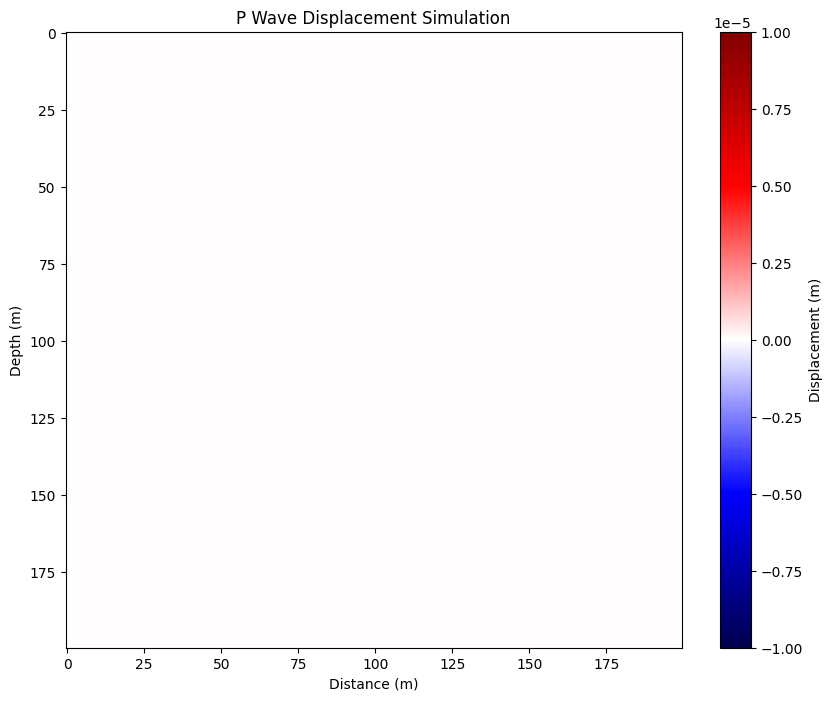

In [8]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(np.sqrt(ux**2 + uy**2).T, cmap='seismic', vmin=-1e-5, vmax=1e-5)

plt.colorbar(img, label='Displacement (m)')
ax.set_title("P Wave Displacement Simulation")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")
plt.show()

In [9]:
def update(frame):
    """Update function for animation"""
    for _ in range(PLOT_EVERY):
        update_p_wave_only(frame * PLOT_EVERY + _)
    
    img.set_array(np.sqrt(ux**2 + uy**2))
    return [img]

ani = FuncAnimation(fig, update, frames=NT//PLOT_EVERY, interval=50, blit=True)

In [10]:
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('test_disp_wave1.mp4', writer=ffmpeg_writer)